In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
# Here cost function is simply the Manhattan distance (absolute diff) between the 2 points
def cost(p1, p2):
    return np.abs(p1 - p2)

In [4]:
# Calculating total cost by summing up the costs in each cluster
def calculateTotalCost(clusters, means):
    totalCost = 0
    for i in range(len(clusters)):
        for point in clusters[i]:
            totalCost += cost(means[i], point) **2

    return totalCost ** 0.5

In [27]:
def kMeans(data, k, showClusters = False, maxIterations = 100, markerSize = 1):
    n = len(data)
    minVal, maxVal = np.min(data), np.max(data)

    assignedClusterIds = np.zeros(n, dtype=int)
    bestClusters = []
    bestMeans = []
    bestAssignedClusterIds = []
    minTotalCost = n * (maxVal - minVal) # This is the maximum possible cost (assume mean is at minVal & all the n points at maxVal)

    # This outermost loop would really be useful when we randomize means instead of uniformly distributing
    # So by default it will run only once
    for iteration in range(maxIterations): 
        clusters = []
        # Initialize means
        means = [np.random.choice(data) for _ in range(k)]
    
        # Repeat the process of readjusting means 20 times
        maxCycles = 50

        # Cluster data by minimizing cost
        for cycle in range(maxCycles):
            clusters = [[] for _ in range(k)]
        
            for index, value in enumerate(data):
                # Max diff between any 2 points
                minCost = maxVal - minVal
                minClusterId = 0

                # Calculate the distance of the point from each mean
                for i in range(k):
                    curCost = cost(means[i], value)

                    # Choose the cluster with closest mean
                    if (curCost < minCost):
                        minCost = curCost
                        minClusterId = i
    
                # Assign the point to the cluster with the nearest mean value
                clusters[minClusterId].append(value)
                assignedClusterIds[index] = minClusterId
            
            # Readjust mean values
            for i in range(k):
                numElements = len(clusters[i])
                if numElements > 0:
                    means[i] = sum(clusters[i]) / numElements
                else:
                    means[i] = np.random.choice(data)

        # Find total cost for current clustering
        totalCost = calculateTotalCost(clusters, means)        
    
        # Choose the overall best clustering
        if (totalCost < minTotalCost):
            minTotalCost = totalCost
            bestClusters = clusters
            bestMeans = means
            bestAssignedClusterIds = assignedClusterIds 

    if (showClusters):
        showClustering(range(n), data, assignedClusterIds, means, markerSize)
    
    return bestClusters, bestMeans, bestAssignedClusterIds

In [28]:
# Plot data by color coding each cluster differently
def showClustering(x, y, assignedClusterIds, SNR, markerSize = 1):
    numColors = 10
    HSV_tuples = [(i/numColors, 1.0, 1.0) for i in range(numColors)]
    RGB_tuples = list(map(lambda x: mcolors.hsv_to_rgb(x), HSV_tuples))
    
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color = RGB_tuples[assignedClusterIds[i] % numColors], s = markerSize)

    # Plot horizontal lines at the support & resistances
    for snrValue in SNR:
        plt.axhline(y=snrValue, color='black', linestyle='--')
        plt.annotate(f'{snrValue}', xy=(1, snrValue), xycoords=('axes fraction', 'data'), textcoords='offset points', xytext=(5, 0), ha='left', va='center', color='black')
        
    plt.show()

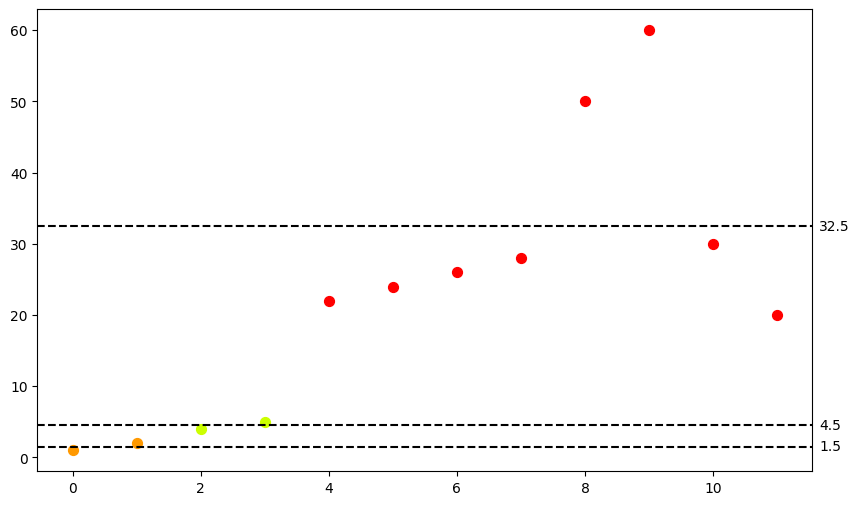

Clusters: [[1, 2, 4, 5], [22, 24, 26, 28, 30, 20], [50, 60]]
Means: [3.0, 25.0, 55.0]
Assigned Cluster Ids: [1 1 2 2 0 0 0 0 0 0 0 0]


In [29]:
points = np.array([1,2,4,5,22,24,26,28,50,60,30,20])

k = 3
clusters, means, assignedClusterIds = kMeans(points, k, True, 10, 50)

print(f'Clusters: {clusters}')
print(f'Means: {means}')
print(f'Assigned Cluster Ids: {assignedClusterIds}')

In [30]:
def autoKMeans(data, maxClusters = 10, showElbowCurve = False, showBestClustering = False):
    totalCosts = [float('inf')] # for 0 clusters, cost is infinity
    
    for k in range(1, min(len(data), maxClusters) + 1):
        clusters, means, _assignedClusterIds = kMeans(data, k)
        totalCosts.append(calculateTotalCost(clusters, means))

    # Find the elbow point - value of k for most optimal clustering (highest reduction in cost on increasing total clusters by 1)
    bestK = 1
    maxAngleDiff = 0
    for k in range(2, len(totalCosts) - 1):
        x1, y1 = 10 * (k - 1), totalCosts[k - 1]
        x2, y2 = 10 * k, totalCosts[k]
        x3, y3 = 10 * (k + 1), totalCosts[k + 1]

        prevAngle = math.degrees(math.atan(abs((y2 - y1) / (x2 - x1))))
        curAngle = math.degrees(math.atan(abs((y3 - y2) / (x3 - x2))))
        angleDiff = prevAngle - curAngle

        # print(prevAngle, curAngle, angleDiff)
        
        if (angleDiff > maxAngleDiff):
            maxAngleDiff = angleDiff
            bestK = k

    # Plotting the totalCosts for each k
    if (showElbowCurve):
        plt.figure(figsize=(10,6))
        plt.plot(range(1, len(totalCosts)), totalCosts[1:], marker='o')
        
        plt.plot(bestK, totalCosts[bestK], marker='o', color='orange')
        plt.annotate('Elbow point', (bestK, totalCosts[bestK]), textcoords="offset points", xytext=(40,10), ha='center')
        
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Total Cost')
        plt.title('Total Cost vs Number of Clusters')
        
        plt.grid(True)
        plt.show()
    
    return kMeans(data, bestK, showBestClustering)

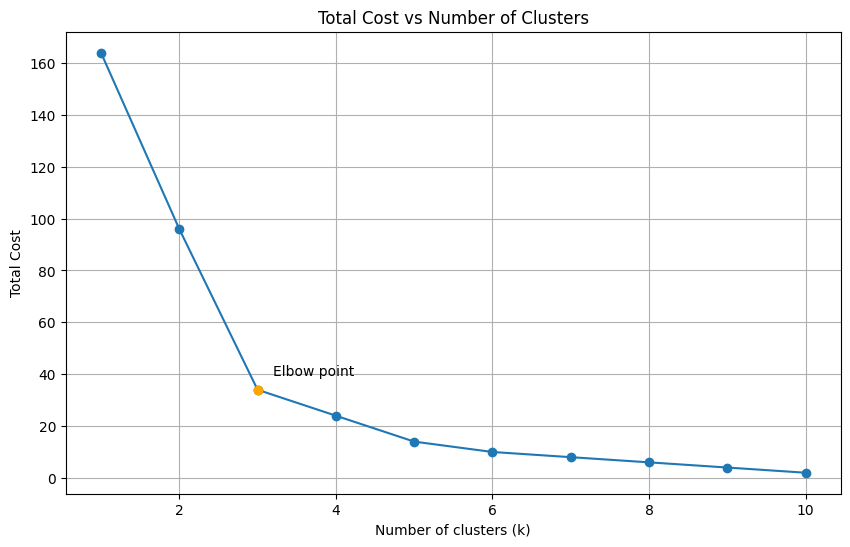

([[1, 2, 4, 5], [50, 60], [22, 24, 26, 28, 30, 20]],
 [3.0, 55.0, 25.0],
 array([0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2]))

In [31]:
autoKMeans(points, 10, True)

In [32]:
# Main
# Load the stock prices of ITC using pandas
dataframe = pd.read_csv('Datasets/SCRIP/ITC.csv')

# Select the relevant attributes and rename them
data = dataframe[['Date', 'Close']].rename(columns = {'Close': 'Price'})

# Convert the price from string to float convert coerce mode converts non-numeric strings to NaN
data['Price'] = pd.to_numeric(data['Price'], errors = 'coerce')

# Convert dates to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Slice the time range
startDate = '2007-01-01'
endDate = '2024-01-01'
data = data[(data['Date'] >= startDate) & (data['Date'] <= endDate)]

# Subtract the initial date from all dates and convert it into days (we only need these indexes to plot)
data['Date'] = (data['Date'] - data['Date'].min()).dt.days

# Drop rows that have NaN values
data = data.dropna()

# Convert single columns into numpy arrays
prices = data['Price'].values
dates = data['Date'].values

print(max(prices))
print(len(prices))
print(prices)
print(dates[0:12]) # Notice that Saturday-Sunday markets are closed

399.7
3594
[177.   175.45 168.95 ... 203.3  202.7  203.  ]
[ 0  1  2  3  6  7  8  9 10 13 14 15]


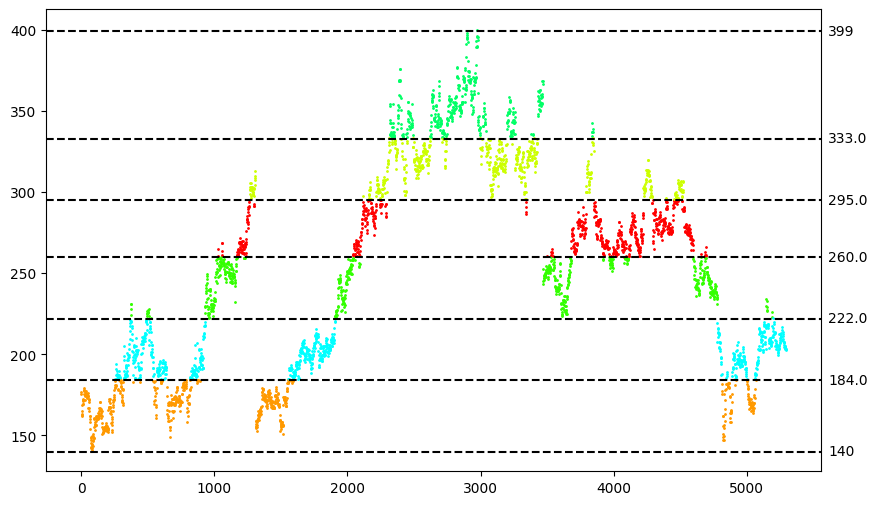

In [33]:
# This is an expensive process. Will take some time depending on your machine.
clusters, means, assignedClusterIds = autoKMeans(prices)

# Calculating all the Support & Resistance lines (SNR)
supports = []
resistances = []

for cluster in clusters:
    supports.append(math.floor(min(cluster)))
    resistances.append(math.floor(max(cluster)))

supports.sort()
resistances.sort()

SNR = [supports[0]] # bottom line

# Middle lines
for i in range(len(clusters) - 1):
    SNR.append((resistances[i] + supports[i + 1]) / 2)

SNR.append(resistances[len(clusters) - 1]) # top line

showClustering(dates, prices, assignedClusterIds, SNR)